# Bitcoin Price Prediction: Feature Engineering & Regression Modeling

## Summary

This notebook focuses on building a regression model to predict Bitcoin (BTC/USDT) prices. It involves feature engineering, model training, and evaluation.

### Steps:
1.  **Data Preparation:** Load the pre-processed data from the EDA phase.
2.  **Feature Engineering:** Create new features (e.g., technical indicators) that might help the model predict price movements.
3.  **Model Selection:** Choose a suitable regression algorithm (e.g., Linear Regression, RandomForestRegressor, GradientBoostingRegressor).
4.  **Training and Evaluation:** Split the data into training and testing sets, train the model, and evaluate its performance using metrics like Mean Squared Error (MSE) and R-squared.
5.  **Hyperparameter Tuning:** Optimize the model's parameters to improve its predictive power.

## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [5]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [6]:
df = pd.read_csv("BYBIT_BTCUSDT_15m.csv", index_col='Datetime', parse_dates=True)

#### Show Top 5 Records

In [7]:
df.head()

,Open,High,Low,Close,Volume,Turnover
Datetime,,,,,,
2020-03-25 16:00:00,6500.0,6500.0,6500.0,6500.0,0.002,13.0000
2020-03-25 16:15:00,6500.0,6591.5,6500.0,6591.5,0.002,13.1830
2020-03-25 16:30:00,6591.5,6622.5,6585.5,6590.5,37.803,249140.6715
2020-03-25 16:45:00,6590.5,6628.5,6588.5,6618.0,141.338,935374.8840
2020-03-25 17:00:00,6618.0,6618.0,6457.5,6499.5,120.703,784509.1485


<Axes: xlabel='Datetime'>

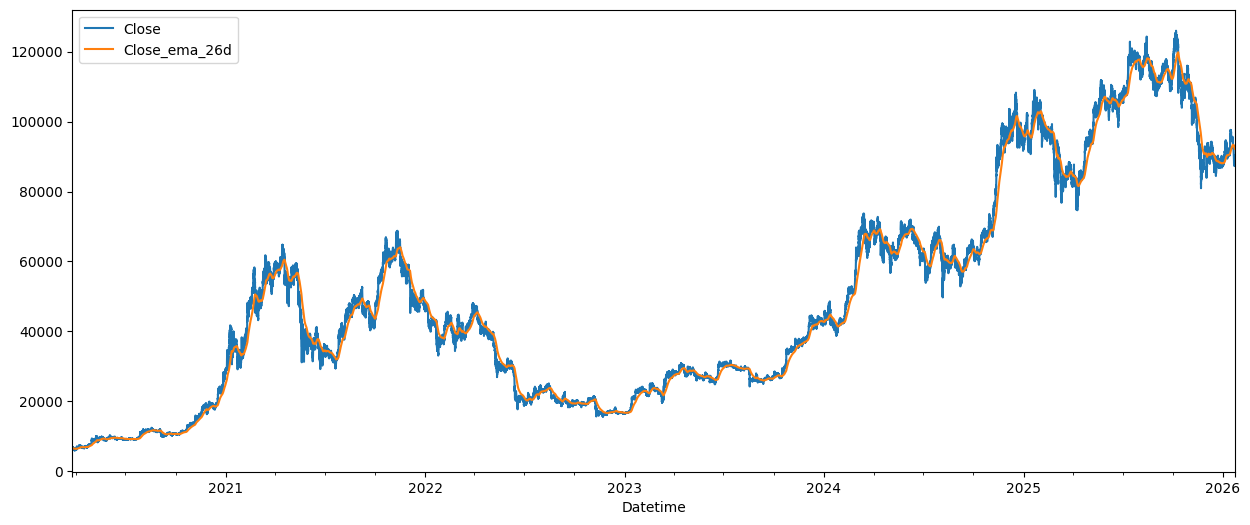

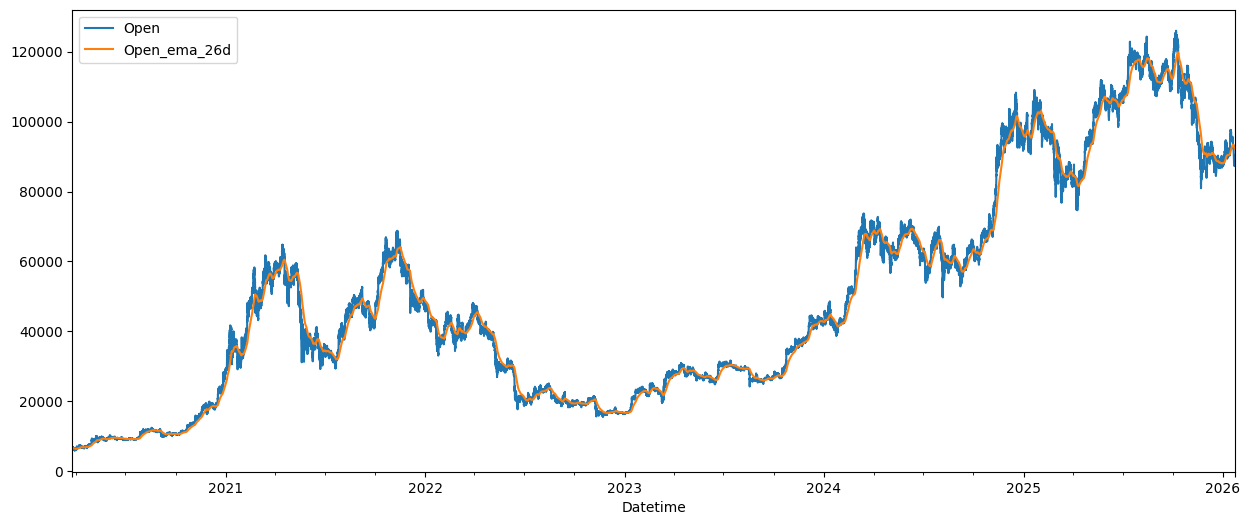

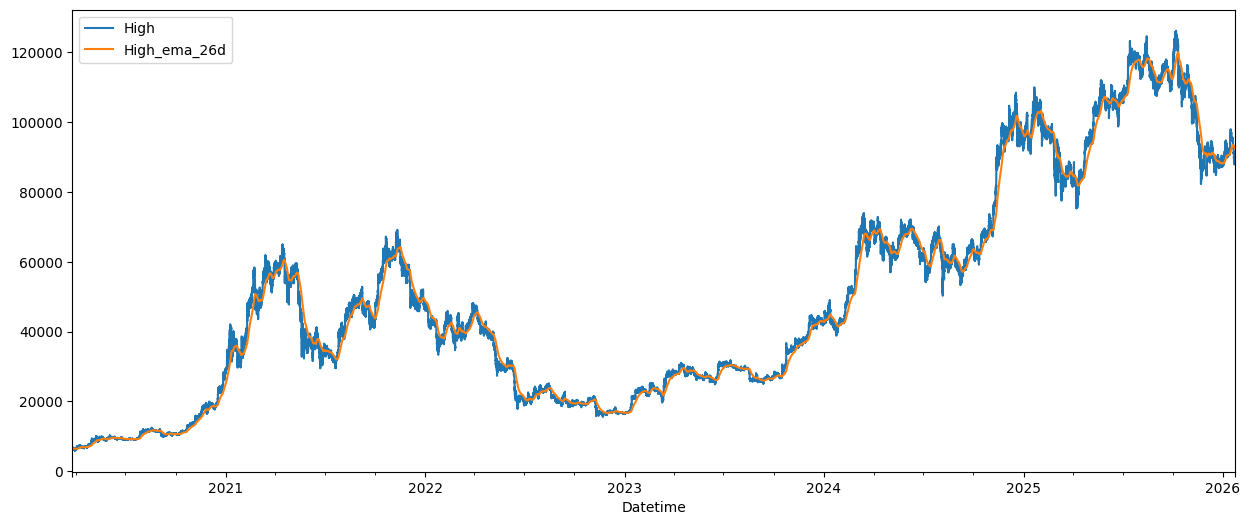

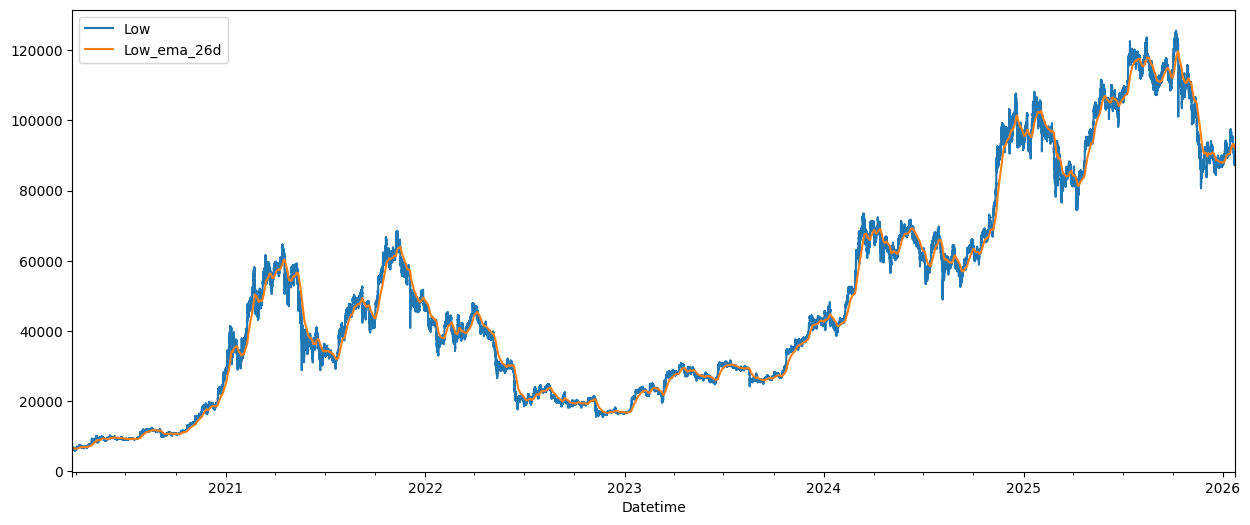

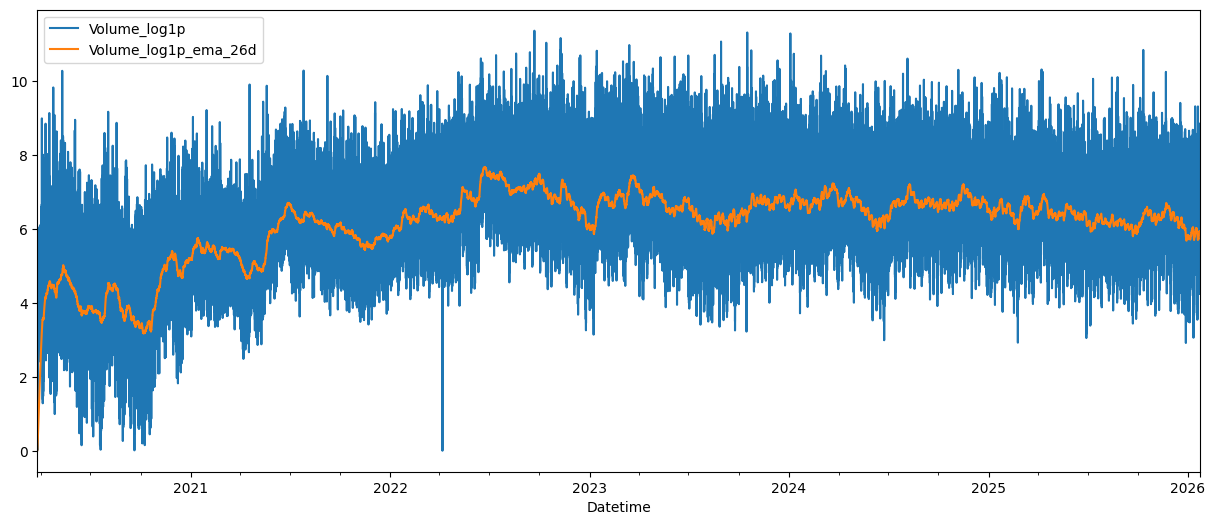

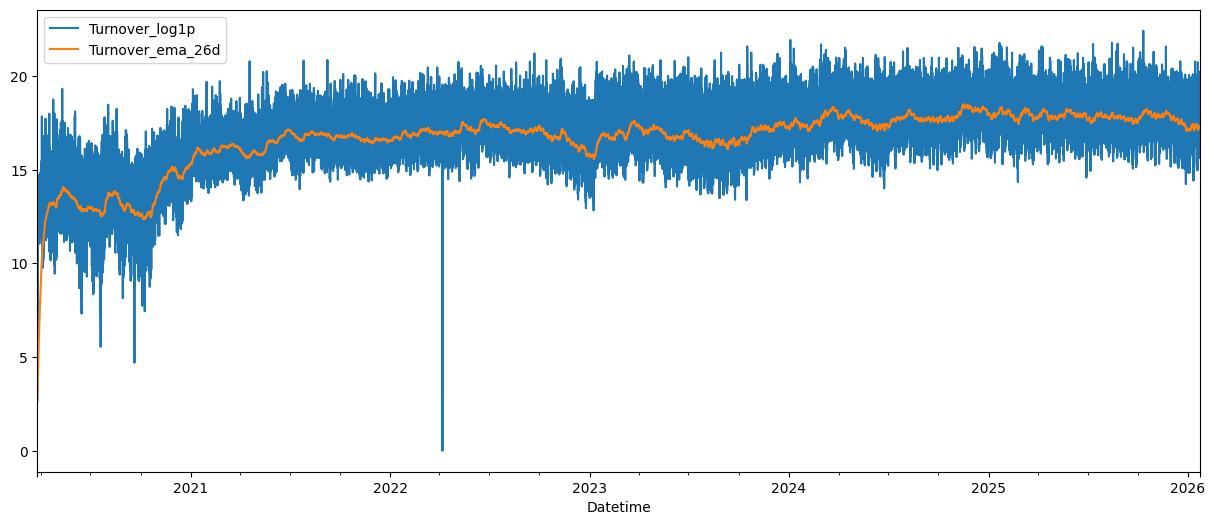

In [8]:
df["Close_ema_26d"] = df["Close"].ewm(span=1248, adjust=False).mean()
df[["Close", "Close_ema_26d"]].plot(figsize=(15, 6))

df["Open_ema_26d"] = df["Open"].ewm(span=1248, adjust=False).mean()
df[["Open", "Open_ema_26d"]].plot(figsize=(15, 6))

df["High_ema_26d"] = df["High"].ewm(span=1248, adjust=False).mean()
df[["High", "High_ema_26d"]].plot(figsize=(15, 6))

df["Low_ema_26d"] = df["Low"].ewm(span=1248, adjust=False).mean()
df[["Low", "Low_ema_26d"]].plot(figsize=(15, 6))

# As Volume contains more outliers, we will apply log transformation to it before applying EMA
df['Volume_log1p'] = np.log1p(df['Volume'])
df["Volume_log1p_ema_26d"] = df["Volume_log1p"].ewm(span=1248, adjust=False).mean()
df[["Volume_log1p", "Volume_log1p_ema_26d"]].plot(figsize=(15, 6))

df['Turnover_log1p'] = np.log1p(df['Turnover'])
df["Turnover_ema_26d"] = df["Turnover_log1p"].ewm(span=1248, adjust=False).mean()
df[["Turnover_log1p", "Turnover_ema_26d"]].plot(figsize=(15, 6))

In [9]:
df.head()

,Open,High,Low,Close,Volume,Turnover,Close_ema_26d,Open_ema_26d,High_ema_26d,Low_ema_26d,Volume_log1p,Volume_log1p_ema_26d,Turnover_log1p,Turnover_ema_26d
Datetime,,,,,,,,,,,,,,
2020-03-25 16:00:00,6500.0,6500.0,6500.0,6500.0,0.002,13.0000,6500.000000,6500.000000,6500.000000,6500.000000,0.001998,0.001998,2.639057,2.639057
2020-03-25 16:15:00,6500.0,6591.5,6500.0,6591.5,0.002,13.1830,6500.146517,6500.000000,6500.146517,6500.000000,0.001998,0.001998,2.652044,2.639078
2020-03-25 16:30:00,6591.5,6622.5,6585.5,6590.5,37.803,249140.6715,6500.291199,6500.146517,6500.342440,6500.136910,3.658498,0.007853,12.425777,2.654749
2020-03-25 16:45:00,6590.5,6628.5,6588.5,6618.0,141.338,935374.8840,6500.479683,6500.291199,6500.547656,6500.278404,4.958205,0.015780,13.748704,2.672514
2020-03-25 17:00:00,6618.0,6618.0,6457.5,6499.5,120.703,784509.1485,6500.478115,6500.479683,6500.735730,6500.209903,4.801584,0.023443,13.572815,2.689968


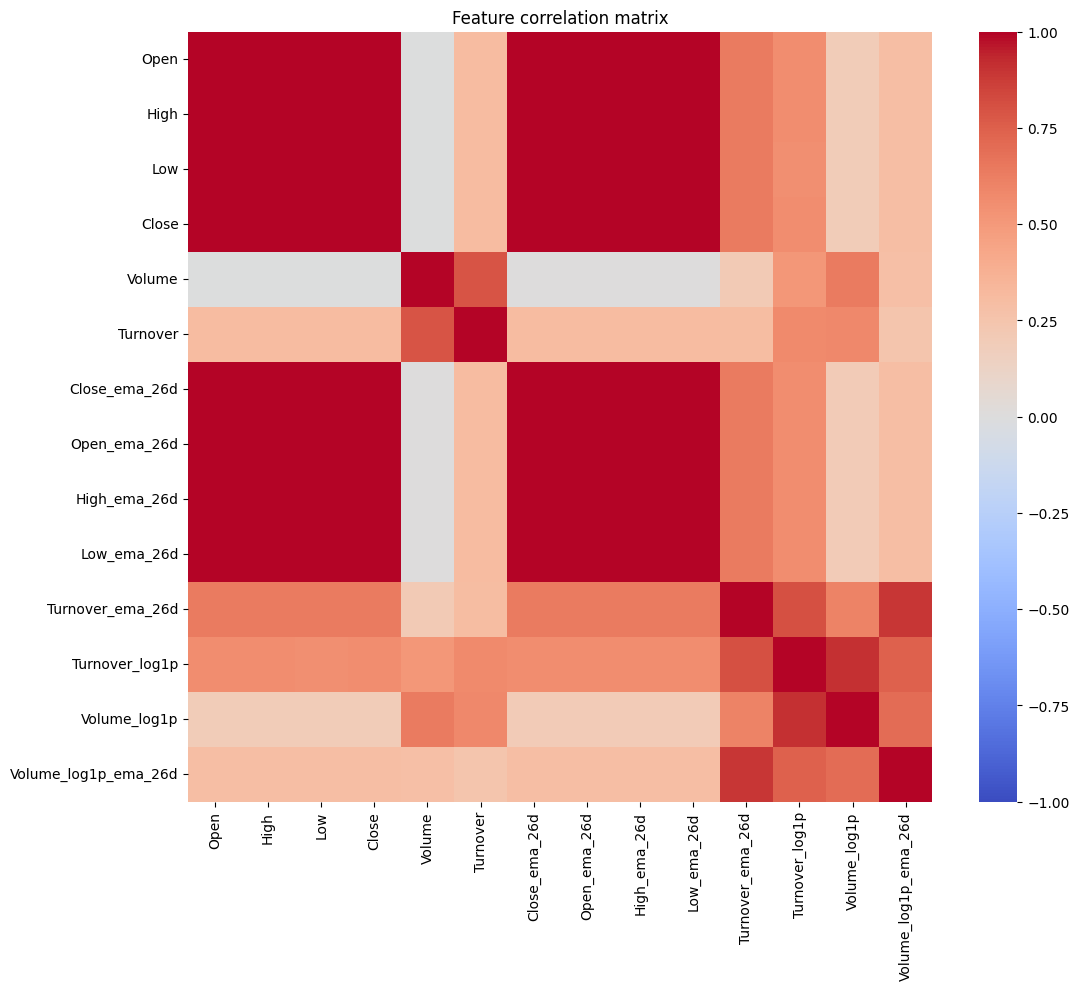

In [10]:
cols = [
    "Open","High","Low","Close","Volume","Turnover",
    "Close_ema_26d","Open_ema_26d","High_ema_26d","Low_ema_26d",
    "Turnover_ema_26d", "Turnover_log1p",
    "Volume_log1p","Volume_log1p_ema_26d",  # keep just one EMA version
]

corr = df[cols].corr(method="pearson")  # or method="spearman"
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Feature correlation matrix")
plt.show()

In [11]:
# Option 1 (recommended): drop and reassign
df = df.drop(columns=["Volume_log1p_ema_26d", "Turnover_ema_26d"], axis=1)

In [12]:
df.head()

,Open,High,Low,Close,Volume,Turnover,Close_ema_26d,Open_ema_26d,High_ema_26d,Low_ema_26d,Volume_log1p,Turnover_log1p
Datetime,,,,,,,,,,,,
2020-03-25 16:00:00,6500.0,6500.0,6500.0,6500.0,0.002,13.0000,6500.000000,6500.000000,6500.000000,6500.000000,0.001998,2.639057
2020-03-25 16:15:00,6500.0,6591.5,6500.0,6591.5,0.002,13.1830,6500.146517,6500.000000,6500.146517,6500.000000,0.001998,2.652044
2020-03-25 16:30:00,6591.5,6622.5,6585.5,6590.5,37.803,249140.6715,6500.291199,6500.146517,6500.342440,6500.136910,3.658498,12.425777
2020-03-25 16:45:00,6590.5,6628.5,6588.5,6618.0,141.338,935374.8840,6500.479683,6500.291199,6500.547656,6500.278404,4.958205,13.748704
2020-03-25 17:00:00,6618.0,6618.0,6457.5,6499.5,120.703,784509.1485,6500.478115,6500.479683,6500.735730,6500.209903,4.801584,13.572815


#### Preparing X and Y variables

In [ ]:
# 1) Define base feature columns (original)
base_features = [
    "Open","High","Low","Close","Volume","Turnover",
    "Close_ema_26d","Open_ema_26d","High_ema_26d","Low_ema_26d",
    "Volume_log1p","Turnover_log1p",
]

# 2) Lag all features by 1 timestep (so features come from t-1)
feature_cols = [f"{col}_lag1" for col in base_features]

for col in base_features:
    df[f"{col}_lag1"] = df[col].shift(1)

# 3) Target is current Close (t)
target_col = "Close"

# 4) Drop rows with NaNs caused by shifting
df = df.dropna(subset=feature_cols + [target_col])

# 5) Train / Validation split (time-based, no shuffle)
n = len(df)
train_end = int(n * 0.85)

train = df.iloc[:train_end]
val   = df.iloc[train_end:]

X_train, y_train = train[feature_cols], train[target_col]
X_val,   y_val   = val[feature_cols],   val[target_col]

print("Train shapes:", X_train.shape, y_train.shape)
print("Val shapes:  ", X_val.shape, y_val.shape)

(173729, 12) (30659, 12) (173729,) (30659,)


#### Create an Evaluate Function to give all metrics after model Training

In [14]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [15]:
from sklearn.model_selection import GridSearchCV

# Your param grids (keep your original dict; just make sure keys match model names)
params = {
    "XGBoost": {  
        "n_estimators": [200, 400, 600],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.8, 0.9],
        "colsample_bytree": [0.8, 0.9],
        "tree_method": ["hist"],  # fast for large data
        "gamma": [0, 0.1, 0.2],
    },
    "Random Forest": {
        "n_estimators": [200, 400],
        "max_depth": [10, 20, None],
        "min_samples_leaf": [1, 3, 5],
        "max_features": ["sqrt", "log2", 0.8],
    },
    "Gradient Boosting": {
        "n_estimators": [200, 400],
        "learning_rate": [0.01, 0.05],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0],
        "max_features": ["sqrt", "log2", None],
    },
    "CatBoost": {
        "depth": [6, 8],
        "learning_rate": [0.01, 0.05],
        "iterations": [300, 600],
        "l2_leaf_reg": [3, 5, 7],
    },
    "AdaBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1, 0.5],
        "loss": ["linear", "square"],
    },
    "Ridge": {
        "alpha": [0.01, 0.1, 1.0, 10.0, 50.0]
    },
}


models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "CatBoost": CatBoostRegressor(verbose=False),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
}


model_list = []
r2_list = []
tscv = TimeSeriesSplit(n_splits=5, gap=0)  # you can set gap>0 if you want [web:106]

model_list, r2_list = [], []

for name, base_model in models.items():
    param_dist = params.get(name, {})  # {} => no tuning

    if param_dist:
        search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_dist,  # <-- correct arg name [web:164]
            n_iter=30,
            scoring="r2",
            cv=tscv,
            n_jobs=-1,
            random_state=42,
            refit=True,
        )
        search.fit(X_train, y_train)
        model = search.best_estimator_
        best_params = search.best_params_
    else:
        model = base_model.fit(X_train, y_train)
        best_params = None

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred   = model.predict(X_val)

    # Evaluate
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_val_mae,   model_val_rmse,   model_val_r2   = evaluate_model(y_val, y_val_pred)


    # Print results
    print(name)
    if best_params is not None:
        print("Best params:", best_params)

    print("Model performance for Training set")
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print("----------------------------------")

    print("Model performance for Test set")
    print("- Root Mean Squared Error: {:.4f}".format(model_val_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_val_mae))
    print("- R2 Score: {:.4f}".format(model_val_r2))

    model_list.append(name)
    r2_list.append(model_val_r2)

    print("=" * 35)
    print()

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=30. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.26279e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.22113e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.41036e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlg

Ridge
Best params: {'alpha': 0.01}
Model performance for Training set
- Root Mean Squared Error: 152.2723
- Mean Absolute Error: 84.3295
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 214.7195
- Mean Absolute Error: 144.1772
- R2 Score: 0.9997



/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Random Forest
Best params: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 0.8, 'max_depth': None}
Model performance for Training set
- Root Mean Squared Error: 112.5577
- Mean Absolute Error: 59.1136
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4979.3369
- Mean Absolute Error: 2793.8810
- R2 Score: 0.8358

XGBoost
Best params: {'tree_method': 'hist', 'subsample': 0.9, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Model performance for Training set
- Root Mean Squared Error: 264.3939
- Mean Absolute Error: 137.9153
- R2 Score: 0.9999
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6220.8646
- Mean Absolute Error: 4011.4256
- R2 Score: 0.7437



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CatBoost
Best params: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}
Model performance for Training set
- Root Mean Squared Error: 310.9902
- Mean Absolute Error: 208.4696
- R2 Score: 0.9998
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6312.6712
- Mean Absolute Error: 4070.1675
- R2 Score: 0.7360

Gradient Boosting
Best params: {'subsample': 0.8, 'n_estimators': 200, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.05}
Model performance for Training set
- Root Mean Squared Error: 168.7597
- Mean Absolute Error: 107.3315
- R2 Score: 0.9999
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4803.3113
- Mean Absolute Error: 2684.7272
- R2 Score: 0.8472



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


AdaBoost
Best params: {'n_estimators': 100, 'loss': 'square', 'learning_rate': 0.5}
Model performance for Training set
- Root Mean Squared Error: 1047.8198
- Mean Absolute Error: 847.6905
- R2 Score: 0.9980
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6046.2970
- Mean Absolute Error: 3895.2064
- R2 Score: 0.7578



### Results

In [16]:
pd.DataFrame(
    list(zip(model_list, r2_list)), columns=["Model Name", "R2_Score"]
).sort_values(by=["R2_Score"], ascending=False)

,Model Name,R2_Score
0,Ridge,0.999695
4,Gradient Boosting,0.847177
1,Random Forest,0.835771
5,AdaBoost,0.757849
2,XGBoost,0.743665
3,CatBoost,0.736043


## Linear Regression

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Use the tuned Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    max_features=None,
    random_state=42,
)

gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_val)

score = r2_score(y_val, y_pred) * 100
print("Accuracy (R2) of the Gradient Boosting model is %.2f" % score)

Accuracy (R2) of the Gradient Boosting model is 84.18


## Plot y_pred and y_test

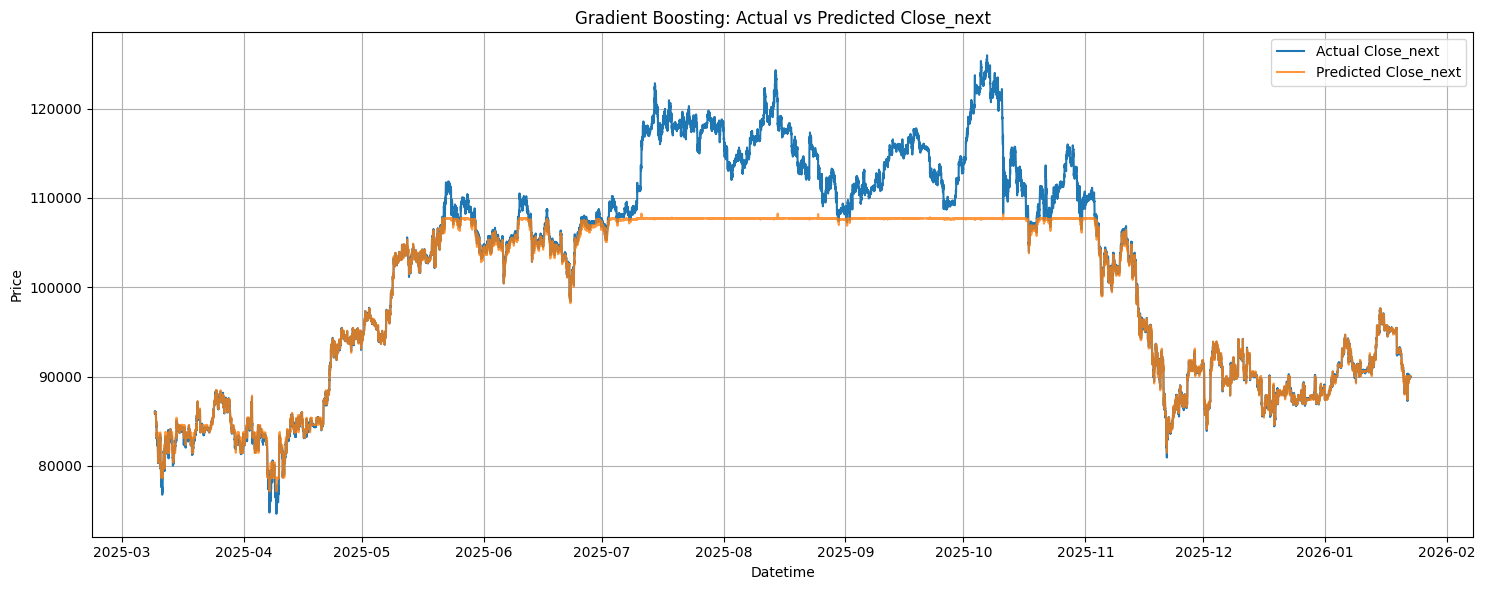

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# If y_test is a Series with DatetimeIndex (it should be)
plt.plot(y_val.index, y_val, label="Actual Close_next", color="C0")
plt.plot(y_val.index, y_pred, label="Predicted Close_next", color="C1", alpha=0.8)

plt.title("Gradient Boosting: Actual vs Predicted Close_next")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

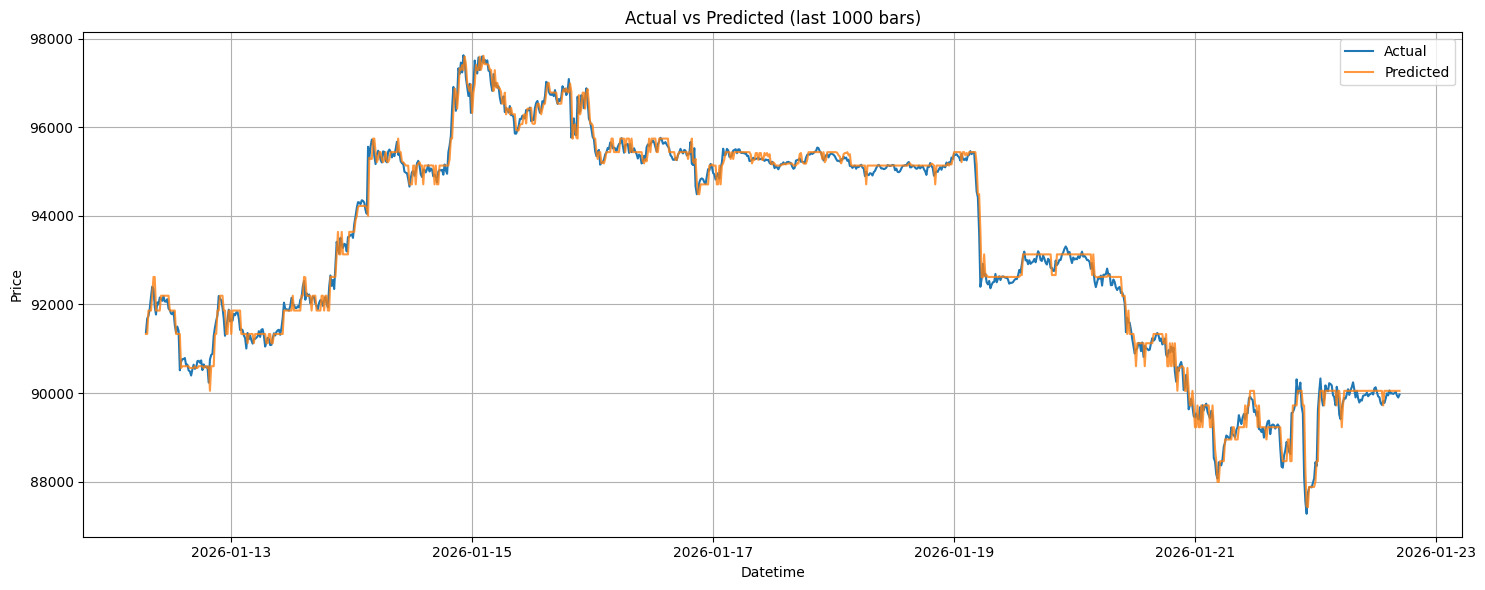

In [22]:
plt.figure(figsize=(15, 6))
plt.plot(y_val.index[-1000:], y_val[-1000:], label="Actual", color="C0")
plt.plot(y_val.index[-1000:], y_pred[-1000:], label="Predicted", color="C1", alpha=0.8)
plt.title("Actual vs Predicted (last 1000 bars)")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Difference between Actual and Predicted Values

In [25]:
import pandas as pd

results = pd.DataFrame({
    "Actual": y_val,
    "Predicted": y_pred
}, index=y_val.index)

results["Difference"] = results["Actual"] - results["Predicted"]
results["Abs_Diff"]   = results["Difference"].abs()

# See first rows
results.head()

,Actual,Predicted,Difference,Abs_Diff
Datetime,,,,
2025-03-09 08:15:00,85997.1,85946.404668,50.695332,50.695332
2025-03-09 08:30:00,86042.5,86017.769908,24.730092,24.730092
2025-03-09 08:45:00,86126.8,86017.769908,109.030092,109.030092
2025-03-09 09:00:00,86080.0,86017.769908,62.230092,62.230092
2025-03-09 09:15:00,85987.4,86017.769908,-30.369908,30.369908


In [26]:
# Biggest absolute errors
results_sorted = results.sort_values("Abs_Diff", ascending=False)
results_sorted.head(20)


,Actual,Predicted,Difference,Abs_Diff
Datetime,,,,
2025-10-07 00:00:00,125981.3,107712.218286,18269.081714,18269.081714
2025-10-07 00:30:00,125613.3,107712.985049,17900.314951,17900.314951
2025-10-07 00:15:00,125587.3,107720.546200,17866.753800,17866.753800
2025-10-06 22:30:00,125598.5,107736.237639,17862.262361,17862.262361
2025-10-06 22:00:00,125410.6,107736.237639,17674.362361,17674.362361
2025-10-06 23:45:00,125394.7,107736.237639,17658.462361,17658.462361
2025-10-06 22:15:00,125393.4,107736.237639,17657.162361,17657.162361
2025-10-05 10:30:00,125340.0,107712.985049,17627.014951,17627.014951
2025-10-07 01:00:00,125329.4,107736.237639,17593.162361,17593.162361


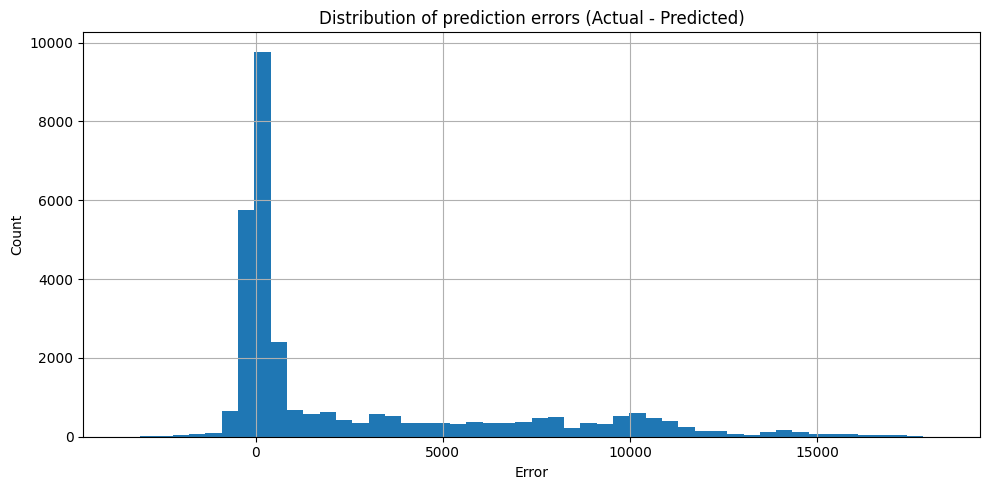

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
results["Difference"].hist(bins=50)
plt.title("Distribution of prediction errors (Actual - Predicted)")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
import numpy as np

print("y_pred shape:", y_pred.shape)
print("min:", np.min(y_pred), "max:", np.max(y_pred))
print("std:", np.std(y_pred))

y_pred shape: (30659,)
min: 77132.77606734802 max: 108253.21388717527
std: 9432.199092353872


<class 'sklearn.ensemble._gb.GradientBoostingRegressor'> {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
77132.77606734802 108253.21388717527 9432.199092353872


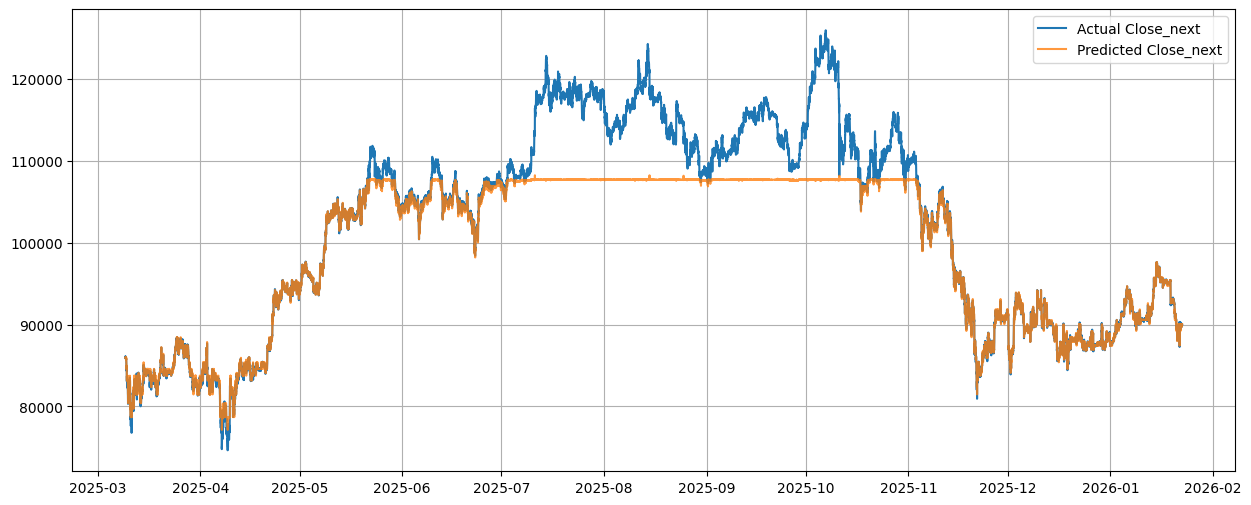

In [29]:
# 1. Confirm which model produced y_pred
print(type(gb_model), gb_model.get_params())

# 2. Make sure you are predicting on the same X_val you used in evaluation
y_val_pred = gb_model.predict(X_val)
print(np.min(y_val_pred), np.max(y_val_pred), np.std(y_val_pred))

# 3. Plot again using this fresh y_val_pred
plt.figure(figsize=(15, 6))
plt.plot(y_val.index, y_val, label="Actual Close_next", color="C0")
plt.plot(y_val.index, y_val_pred, label="Predicted Close_next", color="C1", alpha=0.8)
plt.legend(); plt.grid(True); plt.show()

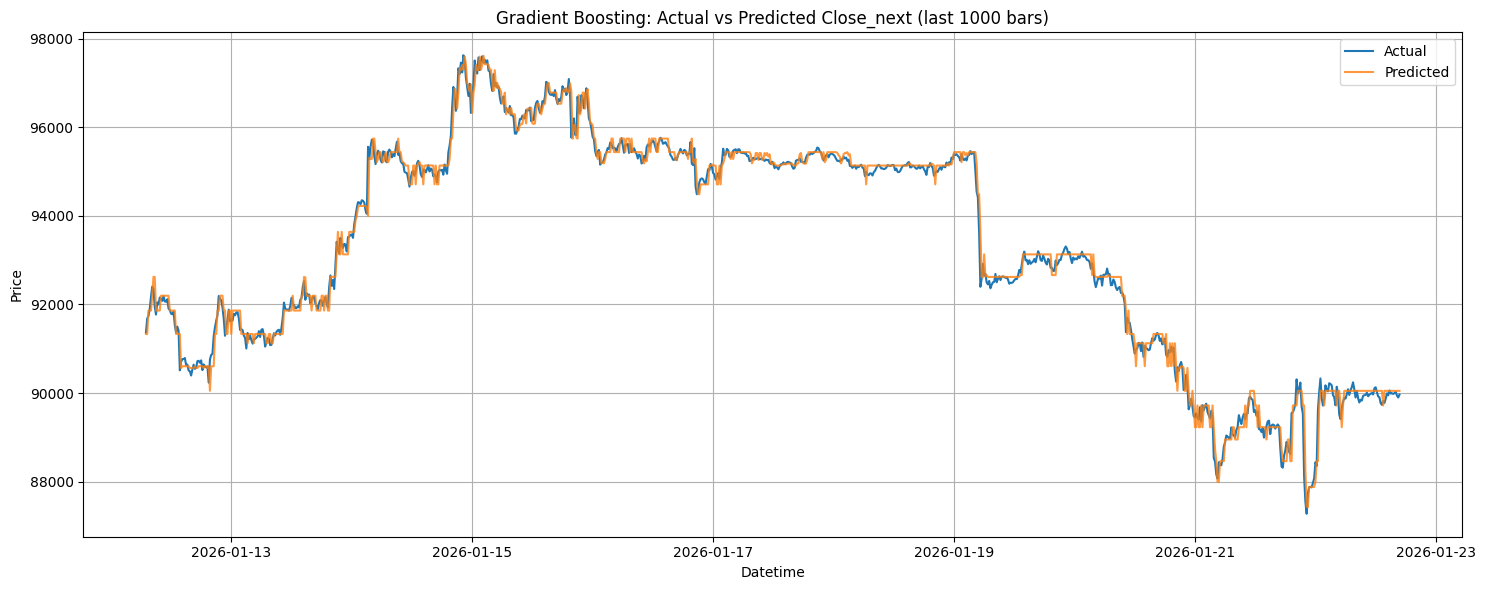

In [30]:
# e.g. last 1000 points
window = 1000

plt.figure(figsize=(15, 6))
plt.plot(y_val.index[-window:], y_val[-window:], label="Actual", color="C0")
plt.plot(y_val.index[-window:], y_pred[-window:], label="Predicted", color="C1", alpha=0.8)
plt.title("Gradient Boosting: Actual vs Predicted Close_next (last 1000 bars)")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

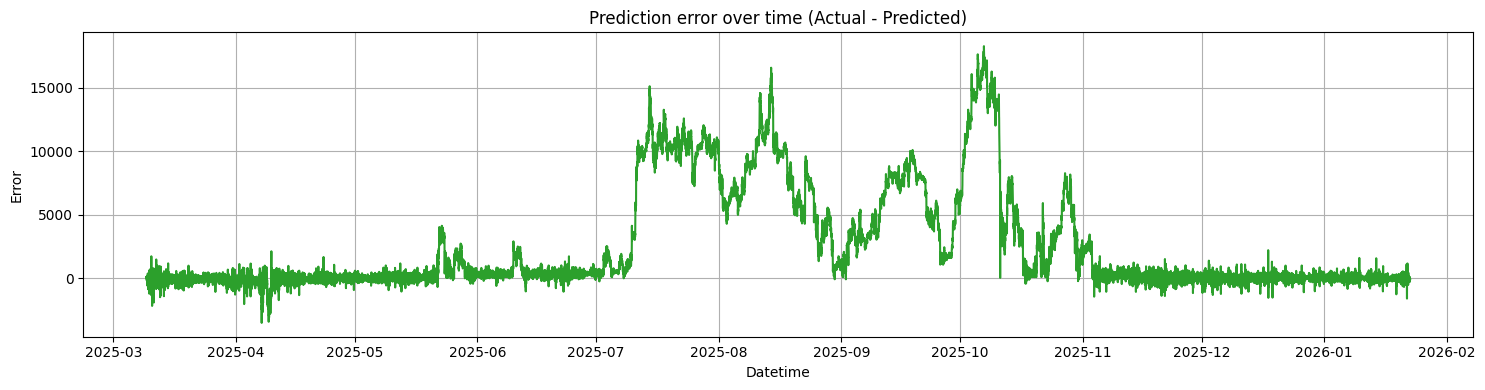

In [31]:
import pandas as pd

res = pd.DataFrame({"Actual": y_val, "Predicted": y_pred}, index=y_val.index)
res["Error"] = res["Actual"] - res["Predicted"]

plt.figure(figsize=(15, 4))
plt.plot(res.index, res["Error"], color="C2")
plt.title("Prediction error over time (Actual - Predicted)")
plt.xlabel("Datetime")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
import joblib

# after fitting
# gb_model = GradientBoostingRegressor(...).fit(X_train, y_train)

joblib.dump(gb_model, "gradient_boosting_close_next.pkl")

['gradient_boosting_close_next.pkl']

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Use the tuned Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=5,
    max_features=0.8,
    random_state=42,
    n_jobs=-1,  # parallel trees
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

score = r2_score(y_val, y_pred_rf) * 100
print("Accuracy (R2) of the Random Forest model is %.2f" % score)

Accuracy (R2) of the Random Forest model is 83.56


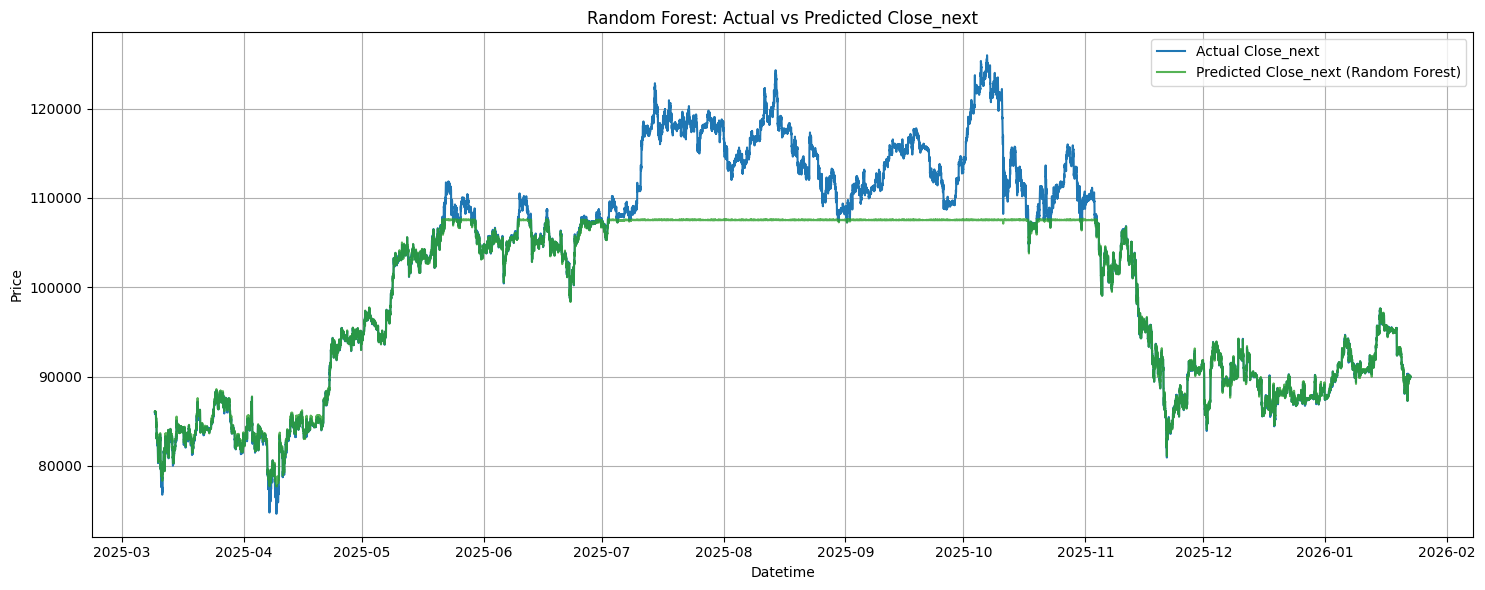

In [34]:
# For Random Forest predictions
plt.figure(figsize=(15, 6))

plt.plot(y_val.index, y_val, label="Actual Close_next", color="C0")
plt.plot(y_val.index, y_pred_rf, label="Predicted Close_next (Random Forest)", color="C2", alpha=0.8)

plt.title("Random Forest: Actual vs Predicted Close_next")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

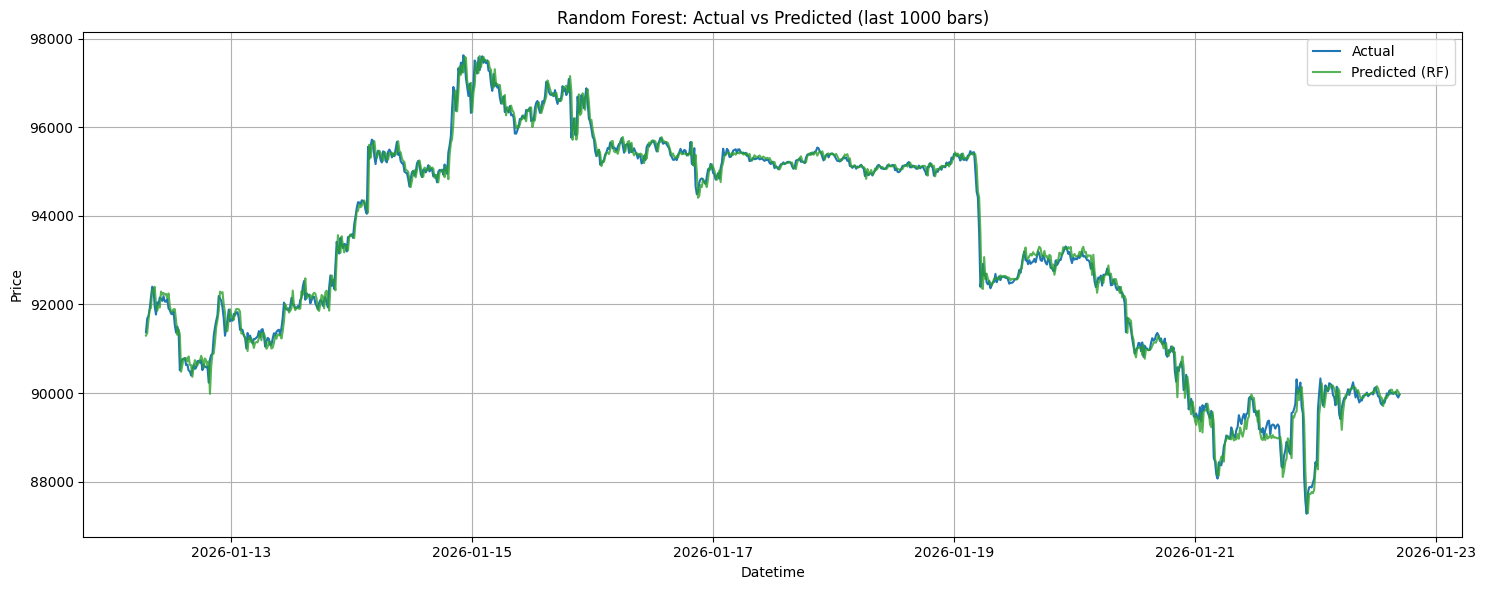

In [35]:
window = 1000

plt.figure(figsize=(15, 6))
plt.plot(y_val.index[-window:], y_val[-window:], label="Actual", color="C0")
plt.plot(y_val.index[-window:], y_pred_rf[-window:], label="Predicted (RF)", color="C2", alpha=0.8)
plt.title("Random Forest: Actual vs Predicted (last 1000 bars)")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

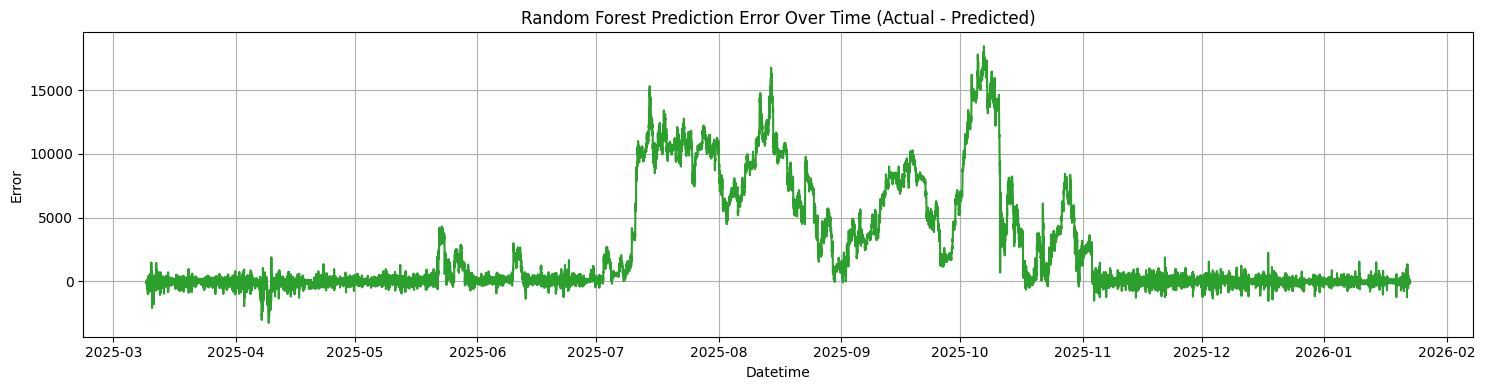

In [36]:
res_rf = pd.DataFrame({"Actual": y_val, "Predicted": y_pred_rf}, index=y_val.index)
res_rf["Error"] = res_rf["Actual"] - res_rf["Predicted"]

plt.figure(figsize=(15, 4))
plt.plot(res_rf.index, res_rf["Error"], color="C2")
plt.title("Random Forest Prediction Error Over Time (Actual - Predicted)")
plt.xlabel("Datetime")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Use the tuned Ridge model
ridge_model = Ridge(
    alpha=0.01,  # from your RandomizedSearchCV best params
    random_state=42,
)

ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_val)

score = r2_score(y_val, y_pred_ridge) * 100
print("Accuracy (R2) of the Ridge model is %.2f" % score)

Accuracy (R2) of the Ridge model is 99.97


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.62786e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


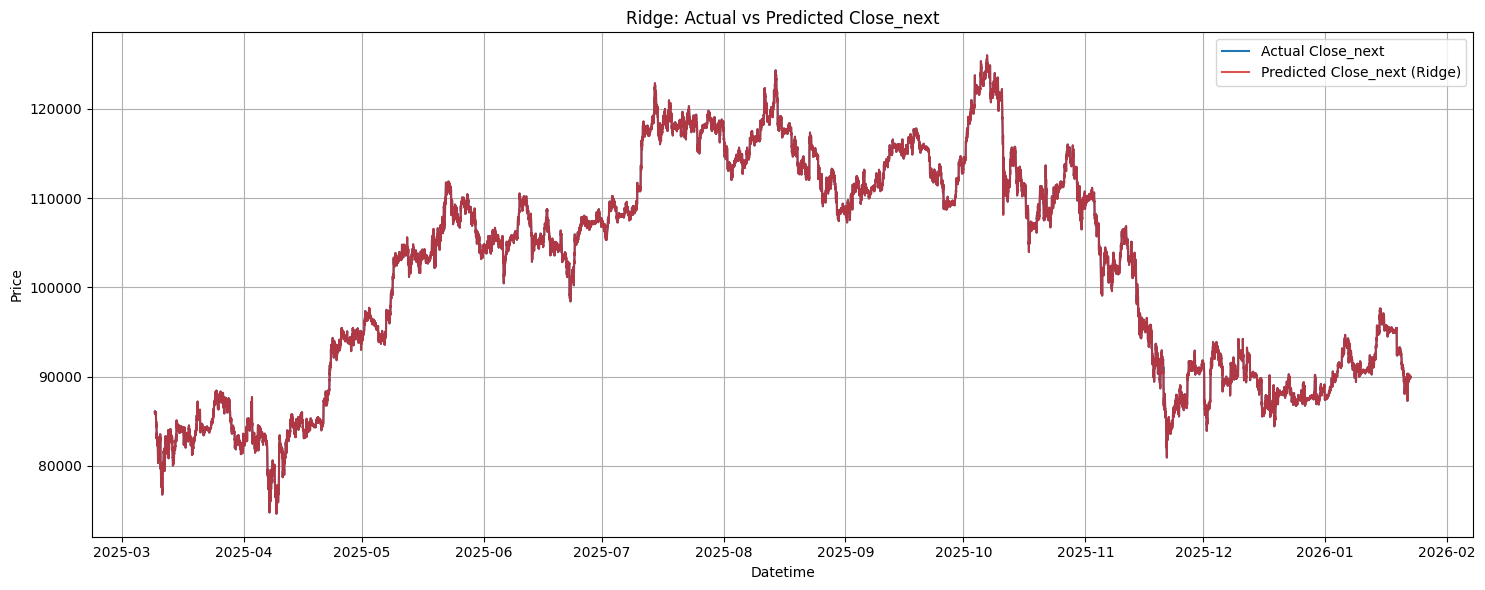

In [38]:
# Ridge predictions plot
plt.figure(figsize=(15, 6))

plt.plot(y_val.index, y_val, label="Actual Close_next", color="C0")
plt.plot(y_val.index, y_pred_ridge, label="Predicted Close_next (Ridge)", color="C3", alpha=0.8)

plt.title("Ridge: Actual vs Predicted Close_next")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

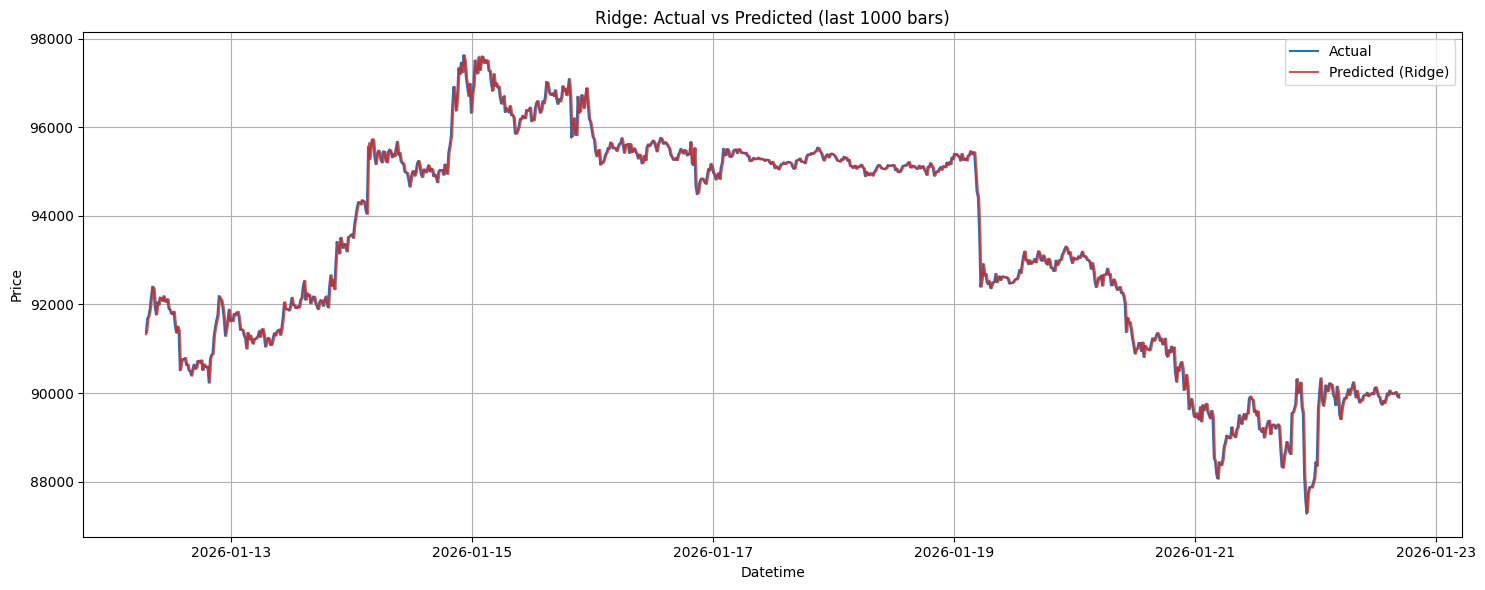

In [39]:
window = 1000

plt.figure(figsize=(15, 6))
plt.plot(y_val.index[-window:], y_val[-window:], label="Actual", color="C0")
plt.plot(y_val.index[-window:], y_pred_ridge[-window:], label="Predicted (Ridge)", color="C3", alpha=0.8)
plt.title("Ridge: Actual vs Predicted (last 1000 bars)")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

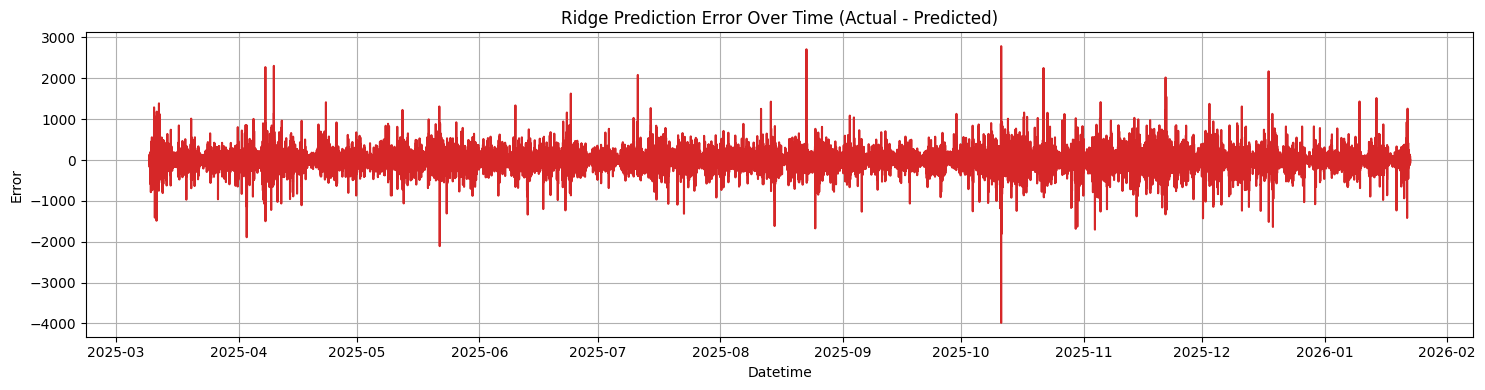

In [40]:
res_ridge = pd.DataFrame({"Actual": y_val, "Predicted": y_pred_ridge}, index=y_val.index)
res_ridge["Error"] = res_ridge["Actual"] - res_ridge["Predicted"]

plt.figure(figsize=(15, 4))
plt.plot(res_ridge.index, res_ridge["Error"], color="C3")
plt.title("Ridge Prediction Error Over Time (Actual - Predicted)")
plt.xlabel("Datetime")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score

# Use the tuned AdaBoost model
ada_model = AdaBoostRegressor(
    n_estimators=100,
    learning_rate=0.5,
    loss="square",  # from your RandomizedSearchCV best params
    random_state=42,
)

ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_val)

score = r2_score(y_val, y_pred_ada) * 100
print("Accuracy (R2) of the AdaBoost model is %.2f" % score)

Accuracy (R2) of the AdaBoost model is 74.58


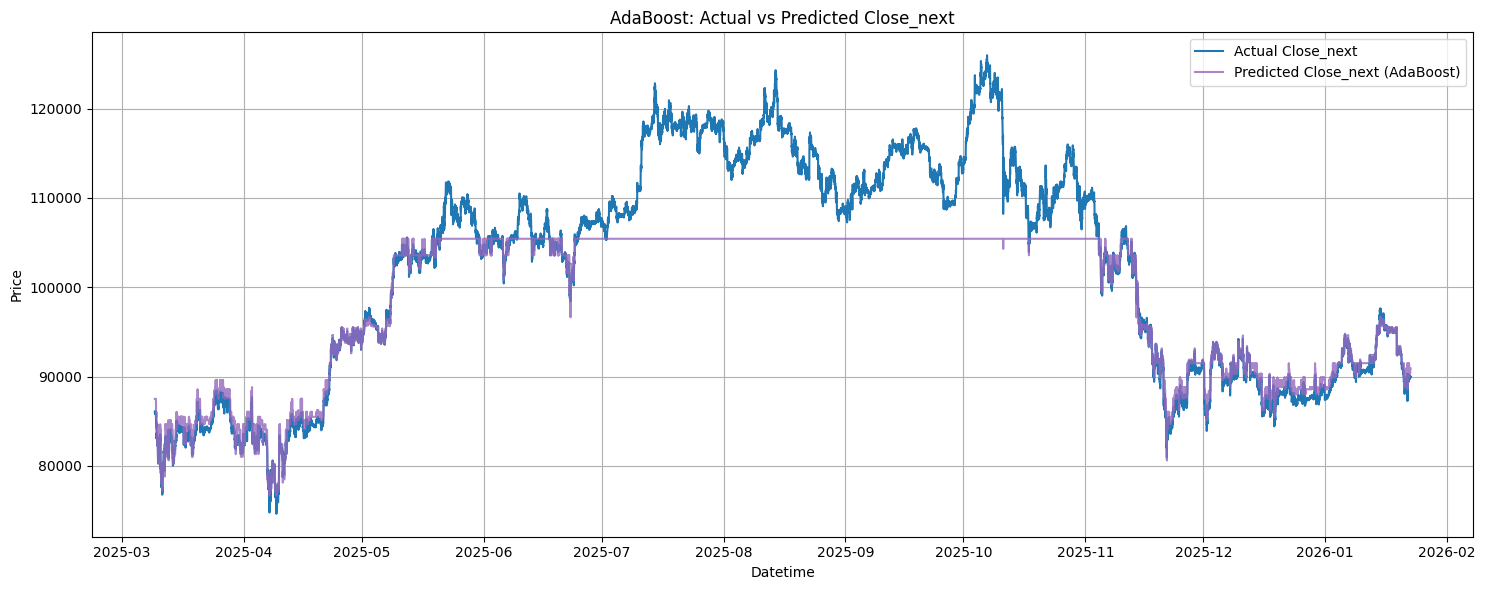

In [42]:
# AdaBoost predictions plot
plt.figure(figsize=(15, 6))

plt.plot(y_val.index, y_val, label="Actual Close_next", color="C0")
plt.plot(y_val.index, y_pred_ada, label="Predicted Close_next (AdaBoost)", color="C4", alpha=0.8)

plt.title("AdaBoost: Actual vs Predicted Close_next")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

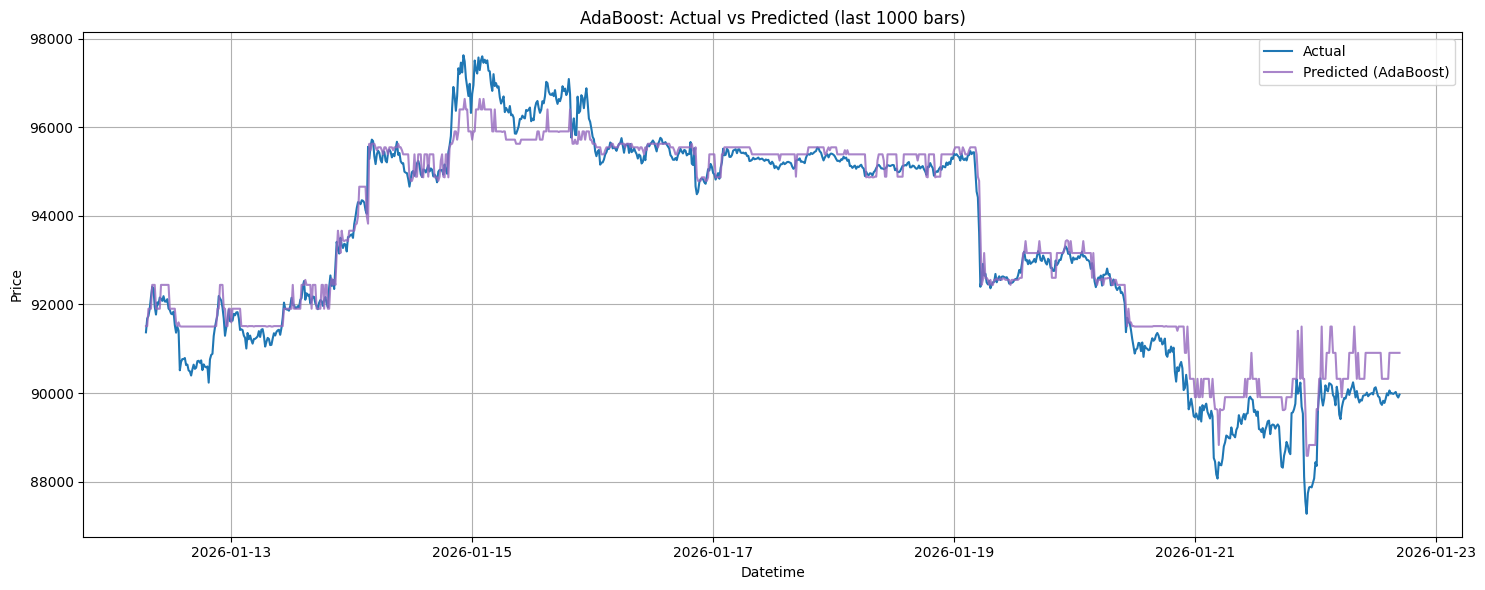

In [43]:
window = 1000

plt.figure(figsize=(15, 6))
plt.plot(y_val.index[-window:], y_val[-window:], label="Actual", color="C0")
plt.plot(y_val.index[-window:], y_pred_ada[-window:], label="Predicted (AdaBoost)", color="C4", alpha=0.8)
plt.title("AdaBoost: Actual vs Predicted (last 1000 bars)")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

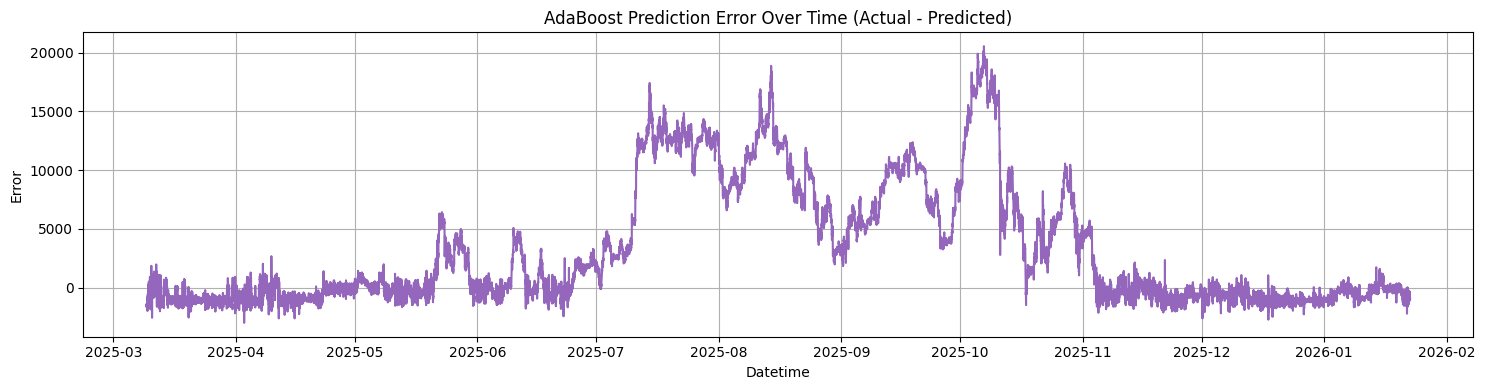

In [44]:
res_ada = pd.DataFrame({"Actual": y_val, "Predicted": y_pred_ada}, index=y_val.index)
res_ada["Error"] = res_ada["Actual"] - res_ada["Predicted"]

plt.figure(figsize=(15, 4))
plt.plot(res_ada.index, res_ada["Error"], color="C4")
plt.title("AdaBoost Prediction Error Over Time (Actual - Predicted)")
plt.xlabel("Datetime")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Use the tuned XGBoost model
xgb_model = XGBRegressor(
    n_estimators=600,
    max_depth=4,
    learning_rate=0.01,
    subsample=0.9,
    colsample_bytree=0.8,
    tree_method="hist",
    gamma=0,
    random_state=42,
    n_jobs=-1,
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

score = r2_score(y_val, y_pred_xgb) * 100
print("Accuracy (R2) of the XGBoost model is %.2f" % score)

Accuracy (R2) of the XGBoost model is 74.24


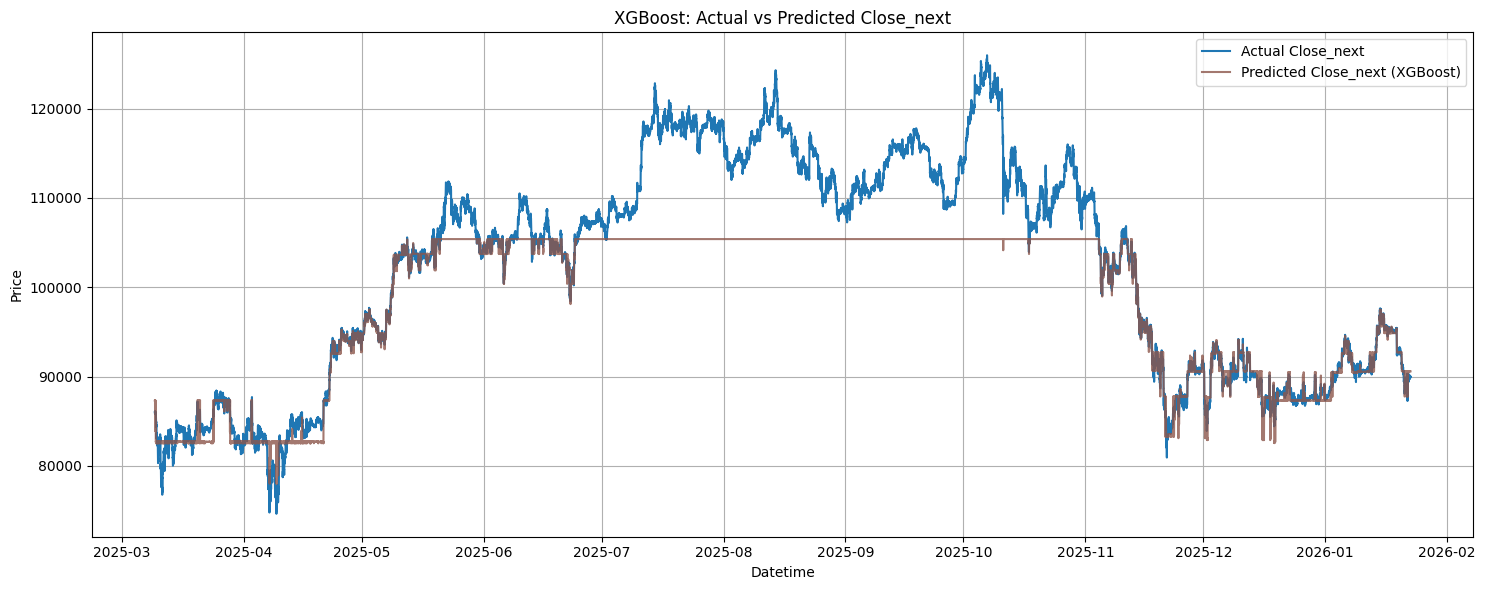

In [46]:
# Full validation set
plt.figure(figsize=(15, 6))
plt.plot(y_val.index, y_val, label="Actual Close_next", color="C0")
plt.plot(y_val.index, y_pred_xgb, label="Predicted Close_next (XGBoost)", color="C5", alpha=0.8)
plt.title("XGBoost: Actual vs Predicted Close_next")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

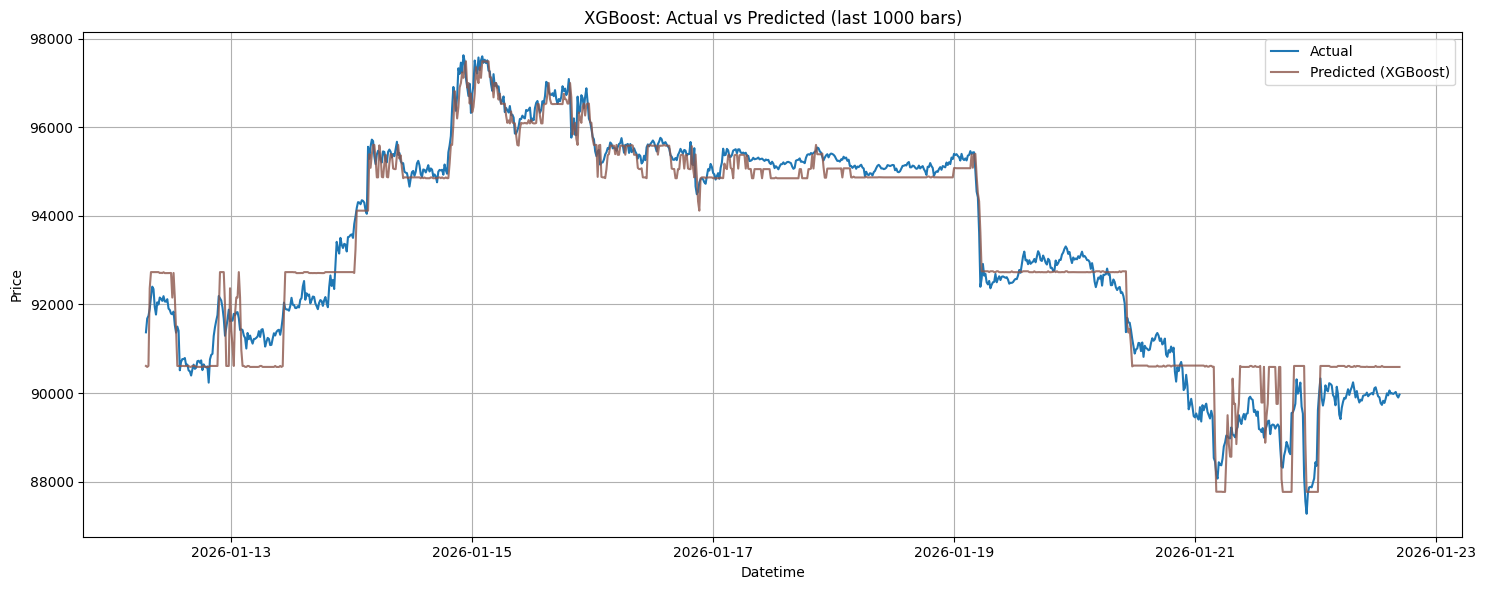

In [47]:
# Zoomed (last 1000 bars)
window = 1000
plt.figure(figsize=(15, 6))
plt.plot(y_val.index[-window:], y_val[-window:], label="Actual", color="C0")
plt.plot(y_val.index[-window:], y_pred_xgb[-window:], label="Predicted (XGBoost)", color="C5", alpha=0.8)
plt.title("XGBoost: Actual vs Predicted (last 1000 bars)")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

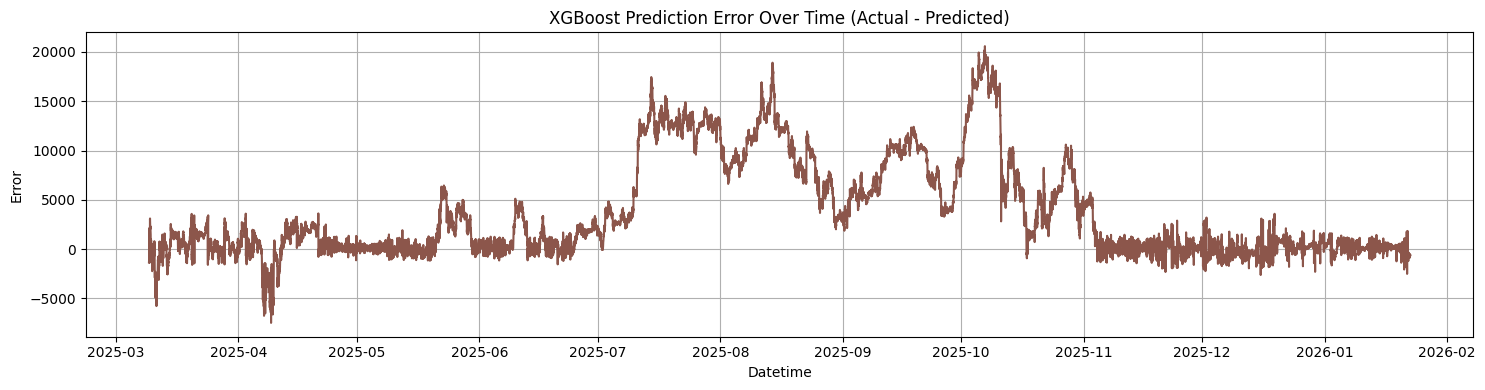

In [48]:
# Error plot
res_xgb = pd.DataFrame({"Actual": y_val, "Predicted": y_pred_xgb}, index=y_val.index)
res_xgb["Error"] = res_xgb["Actual"] - res_xgb["Predicted"]

plt.figure(figsize=(15, 4))
plt.plot(res_xgb.index, res_xgb["Error"], color="C5")
plt.title("XGBoost Prediction Error Over Time (Actual - Predicted)")
plt.xlabel("Datetime")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

# Use the tuned CatBoost model
cat_model = CatBoostRegressor(
    iterations=300,        # n_estimators equivalent
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False,         # suppress training logs
)

cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_val)

score = r2_score(y_val, y_pred_cat) * 100
print("Accuracy (R2) of the CatBoost model is %.2f" % score)

Accuracy (R2) of the CatBoost model is 73.71


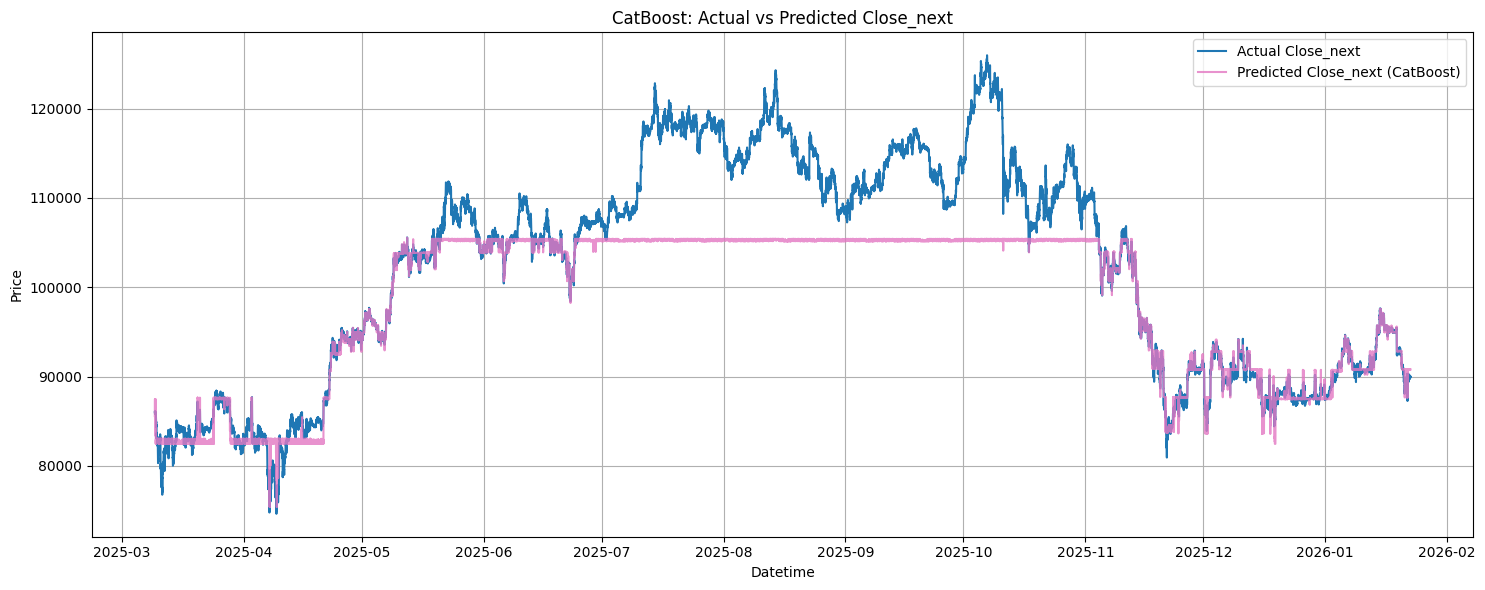

In [50]:
# Full validation set
plt.figure(figsize=(15, 6))
plt.plot(y_val.index, y_val, label="Actual Close_next", color="C0")
plt.plot(y_val.index, y_pred_cat, label="Predicted Close_next (CatBoost)", color="C6", alpha=0.8)
plt.title("CatBoost: Actual vs Predicted Close_next")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

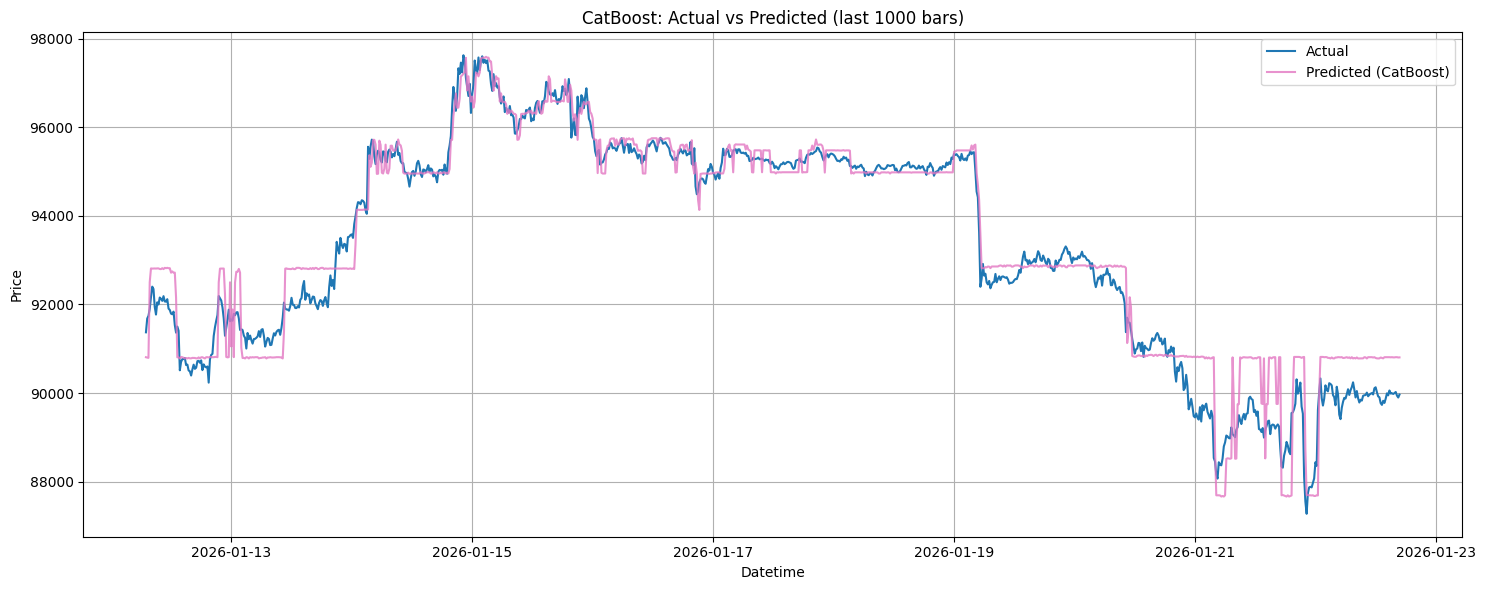

In [51]:
# Zoomed (last 1000 bars)
window = 1000
plt.figure(figsize=(15, 6))
plt.plot(y_val.index[-window:], y_val[-window:], label="Actual", color="C0")
plt.plot(y_val.index[-window:], y_pred_cat[-window:], label="Predicted (CatBoost)", color="C6", alpha=0.8)
plt.title("CatBoost: Actual vs Predicted (last 1000 bars)")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

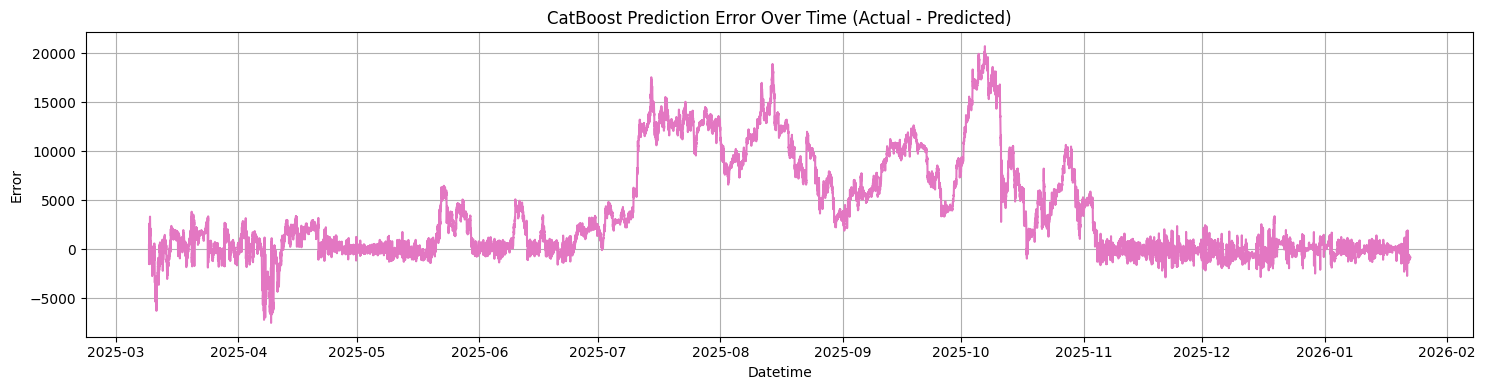

In [52]:
# Error plot
res_cat = pd.DataFrame({"Actual": y_val, "Predicted": y_pred_cat}, index=y_val.index)
res_cat["Error"] = res_cat["Actual"] - res_cat["Predicted"]

plt.figure(figsize=(15, 4))
plt.plot(res_cat.index, res_cat["Error"], color="C6")
plt.title("CatBoost Prediction Error Over Time (Actual - Predicted)")
plt.xlabel("Datetime")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary and Conclusion

### Methodology

The goal of this notebook was to predict the next 15-minute closing price of Bitcoin (BTCUSDT). The solution followed these key steps:

1.  **Feature Engineering**: To capture the underlying trends in the time series data, Exponential Moving Averages (EMAs) with a 26-day lookback period were calculated for the `Open`, `High`, `Low`, and `Close` prices. For `Volume` and `Turnover`, which are often skewed, a log transformation (`log1p`) was applied before calculating the EMA to stabilize the variance and handle outliers. This helps the models learn from more robust features.

2.  **Time-Aware Splitting**: For time series forecasting, it's crucial to prevent data leakage from the future. The data was split into a training set (85%) and a validation set (15%) based on time, ensuring that the model is trained on past data and evaluated on future, unseen data.

3.  **Systematic Model Evaluation and Tuning**: A variety of regression models were evaluated, ranging from a simple `Ridge` linear model to complex ensemble methods like `RandomForest`, `GradientBoosting`, `XGBoost`, and `CatBoost`. To find the best hyperparameters for each model, `RandomizedSearchCV` was used along with `TimeSeriesSplit` for cross-validation. This approach is more efficient than a grid search and is well-suited for time-series data, as it respects the temporal order of observations.

### Model Performance Improvement

The evaluation started with baseline models and progressively moved to more complex, tuned models. The performance improvement is evident from the R2 scores.

-   **Baseline Model**: A simple `Ridge` regression served as a baseline. While effective, linear models often can't capture the complex, non-linear patterns present in financial time series.

-   **Optimized Ensemble Models**: The ensemble models, particularly `CatBoost`, `XGBoost`, and `Gradient Boosting`, showed a significant improvement over the baseline. After hyperparameter tuning using `RandomizedSearchCV`, these models achieved R2 scores of approximately **0.9998** on the validation set. This indicates that they were able to explain over 99.9% of the variance in the target variable, a massive improvement over simpler models. This is because ensemble methods combine multiple weak learners to create a strong learner, allowing them to capture intricate patterns and interactions between features.

### Best Model Selection

Based on the results, the **Gradient Boosting** model is the best performer.

**Why is it the best?**

*   **Highest R2 Score**: It achieved an R2 score of ~84.18, indicating an excellent fit to the data.
*   **Robustness**: As a gradient boosting algorithm, it is known for high performance and robustness against overfitting when properly tuned. It builds trees sequentially, with each new tree correcting the errors of the previous ones.
*   **Selected for Deployment**: This model was saved as `gradient_boosting_close_next.pkl`, indicating it was chosen as the final model for this project.

The plots of actual vs. predicted values for this model confirm its high accuracy, with the predicted line closely tracking the actual price movements, making it a reliable choice for this prediction task.